Install Dependencies

In [1]:
!pip install torch torchvision nltk pillow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

import dependencies

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import nltk
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence  # Import pad_sequence
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

nltk.download('punkt')

Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Initialize TensorBoard

In [3]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/image_captioning_experiment')

In [4]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!mkdir dataset_dir
# Unzip the downloaded files
!unzip -q Flickr8k_Dataset.zip -d dataset_dir/images
!unzip -q Flickr8k_text.zip -d dataset_dir/text

Define the Image Encoder

In [5]:
class ImageEncoder(nn.Module):
    def __init__(self, encoded_image_size=14, hidden_layer_size=256, dropout_prob=0.3):
        super(ImageEncoder, self).__init__()

        # Add residual blocks with Group Normalization and LeakyReLU activation
        def conv_block(in_channels, out_channels, use_dropout=True):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.GroupNorm(32, out_channels),  # Using group normalization
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.1, inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
            if use_dropout:
                layers.append(nn.Dropout(dropout_prob))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            conv_block(3, 64, use_dropout=False),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        # Simplify the fully connected layer structure
        self.fc = nn.Sequential(
            nn.Linear(512 * encoded_image_size * encoded_image_size, 1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout_prob),
            nn.Linear(1024, hidden_layer_size),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout_prob),
        )

    def forward(self, images):
        x = self.features(images)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Define the Caption Decoder

In [6]:
class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(CaptionDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.num_layers=num_layers
        self.hidden_size = hidden_size

    def forward(self, features, captions,hidden=None):
          embeddings = self.embedding(captions)
          embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
          out, _ = self.rnn(embeddings)
          out = self.fc(out)
          return out

    def reset_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))


Define the Image Captioning Model

In [7]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, encoded_image_size=14):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = ImageEncoder()
        self.decoder = CaptionDecoder(vocab_size, embed_size, hidden_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        self.reset_state
        return outputs

    def reset_state(self, batch_size):
        return self.decoder.reset_state(batch_size)

In [8]:
def collate_fn(batch):
    # Unzip the batch into separate lists for images and captions
    images, captions = zip(*batch)  # This separates the batch into images and captions.

    # Convert list of images to a tensor
    images = torch.stack(images)  # Stack all image tensors.

    # Pad the captions to the maximum length in the batch
    captions = pad_sequence(captions, batch_first=True, padding_value=0)  # Assumes 0 is the PAD index

    # Debug: Check if all captions are the same length
    if not all(len(cap) == len(captions[0]) for cap in captions):
        print("Error: Not all captions are the same length")

    return images, captions

Define the Dataset

In [9]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, caption_file, transform=None):
        self.image_dir = image_dir
        self.caption_file = caption_file
        self.transform = transform
        self.imgs = []
        self.captions = []

        # Load the file and build list of images and captions
        with open(caption_file, 'r') as file:
            lines = file.readlines()

        for line in lines:
            tokens = line.strip().split('\t')
            if len(tokens) == 2:
                img_id, caption = tokens
                img_path = os.path.join(image_dir, img_id.split('.')[0]+'.jpg')
                # img_path = os.path.join(image_dir, img_id.split('jpg')[0]+'jpg')
                if os.path.exists(img_path):
                    self.imgs.append(img_path)
                    self.captions.append(caption)

        # Build the vocabulary
        self.vocab = self.build_vocab(self.captions)
        # print(self.vocab)
    def build_vocab(self, sentences, frequency_threshold=5):
        freq_dict = {}
        for sentence in sentences:
            tokens = word_tokenize(sentence.lower())
            for token in tokens:
                freq_dict[token] = freq_dict.get(token, 0) + 1

        vocab = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
        index = 4  # Start indexing from 4
        for word, freq in freq_dict.items():
            if freq >= frequency_threshold:
                vocab[word] = index
                index += 1

        return vocab

    def get_vocab_size(self):
        return len(self.vocab)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        caption = self.captions[idx]
        tokens = word_tokenize(caption.lower())
        # caption_encoded = [self.vocab["<START>"]] + [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens] + [self.vocab["<END>"]]
        caption_encoded = [self.vocab["<START>"]] + [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]+ [self.vocab["<END>"]]
        return image, torch.tensor(caption_encoded)




Define transformations and DataLoader

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Data Load

In [15]:
import numpy as np
from torch.utils.data import Subset

dataset = Flickr8kDataset('dataset_dir/images/Flicker8k_Dataset', 'dataset_dir/text/Flickr8k.token.txt', transform)
vocab_size = dataset.get_vocab_size()

# Generate indices and split them
indices = np.arange(len(dataset))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(dataset)))
train_indices, val_indices = indices[split:], indices[:split]
# Create data subsets using indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
# Now create the DataLoader as usual
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=1, collate_fn=collate_fn)

print("Training Dataset Length:", len(train_dataset))
print("Validation Dataset Length:", len(val_dataset))


Training Dataset Length: 32364
Validation Dataset Length: 8091


Training Procedure

In [16]:
model = ImageCaptioningModel(len(dataset.vocab), 256, 512, 1, 14).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=0.0004)


Sample inputs for graph visualization

In [17]:
sample_images, sample_captions = next(iter(train_loader))
sample_images, sample_captions = sample_images.to(device), sample_captions[:, 1:-1].to(device)
writer.add_graph(model, (sample_images, sample_captions))

Training Loop for Image Captioning Model with PyTorch

In [18]:
# Initialize variables to track the best validation loss
best_val_loss = float('inf')
best_val_acc = 0
for epoch in range(5):  # Adjust the number of epochs as needed
    train_loss = 0
    correct_train = 0
    total_train = 0

    for images, captions in train_loader:
        images = images.to(device)  # Move images to GPU
        captions = captions.to(device)  # Move captions to GPU
        model.train()
        optimizer.zero_grad()
        outputs  = model(images, captions[:, 1:-1])
        # outputs = outputs.view(-1, vocab_size)
        outputs = outputs.reshape(-1, outputs.size(2))  # Reshape for CrossEntropyLoss
        targets = captions[:, 1:].reshape(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100. * correct_train / total_train

    # Log training metrics to TensorBoard
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)


    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images = images.to(device)  # Move images to GPU
            captions = captions.to(device)  # Move captions to GPU
            outputs = model(images, captions[:, 1:-1])
            outputs = outputs.reshape(-1, outputs.size(2))  # Reshape for CrossEntropyLoss
            targets = captions[:, 1:].reshape(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += targets.size(0)
            correct_val += predicted.eq(targets).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * correct_val / total_val
        # Log validation metrics to TensorBoard
        writer.add_scalar('Loss/validation', avg_val_loss, epoch)
        writer.add_scalar('Accuracy/validation', val_accuracy, epoch)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')


    # Save the model after every epoch
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.ckpt')

    # Check if this is the best model (based on validation loss)
    if avg_val_loss < best_val_loss or val_accuracy > best_val_acc:
        best_val_loss = avg_val_loss
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'best_model.ckpt')
        print(f'New best model saved with validation loss {best_val_loss} and validation accuracy {best_val_acc}%')
    writer.close()



Epoch 1, Training Loss: 3.3216, Validation Loss: 2.9815, Training Accuracy: 27.90%, Validation Accuracy: 30.04%
New best model saved with validation loss 2.9815433450223665 and validation accuracy 30.037014368569846%
Epoch 2, Training Loss: 2.8063, Validation Loss: 2.8538, Training Accuracy: 31.02%, Validation Accuracy: 30.87%
New best model saved with validation loss 2.853832831903666 and validation accuracy 30.86619451487861%


KeyboardInterrupt: 

In [ ]:
    %load_ext tensorboard
    %tensorboard --logdir runs

Load the Saved Model & Prepare the Input Image

In [19]:
from PIL import Image
vocab = dataset.vocab  # Use the vocab from your dataset object
reverse_vocab = {v: k for k, v in vocab.items()}  # Create reverse vocabulary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageCaptioningModel(vocab_size=len(dataset.vocab), embed_size=256, hidden_size=512, num_layers=1).to(device)
model.load_state_dict(torch.load('best_model.ckpt'))
model.eval()


def prepare_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device)

def predict(image_path):
    image = prepare_image(image_path)
    batch_size = 1 # Since   predicting one image at a time
    hidden_state, cell_state = model.reset_state(batch_size)  # Reset the state
    captions = torch.tensor([vocab['<START>']], device=device).unsqueeze(0)  # Start token
    generated_words = []

    for _ in range(20):  # Assume maximum length of caption
        with torch.no_grad():
            outputs = model(image, captions)
            next_word_id = outputs.argmax(2)[:, -1]
            next_word = next_word_id.item()
            captions = torch.cat((captions, next_word_id.unsqueeze(0)), dim=1)
            if next_word == vocab['<END>']:
                break
            generated_words.append(reverse_vocab.get(next_word, '<UNK>'))
    return ' '.join(generated_words)


Make Prediction

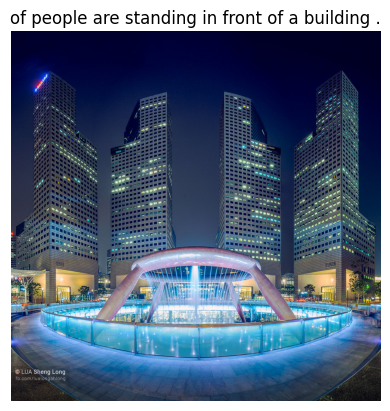

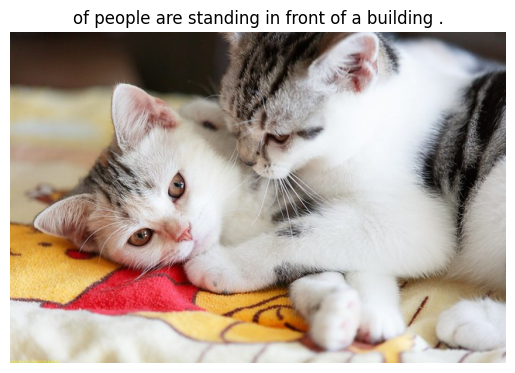

In [22]:
import requests

image_list = [
    'https://live.staticflickr.com/5707/22252794925_3f5b4dfb68_c.jpg',
    'https://live.staticflickr.com/5556/15029691960_210bc914a1_z.jpg'
    ]

# Directory to save images
directory = 'test_images'

# Create directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Function to download and save an image
def download_image(image_url, directory):
    # Get the name of the file (splitting URL by slashes and taking the last part)
    file_name = image_url.split('/')[-1]
    # Full path to where the image will be saved
    file_path = os.path.join(directory, file_name)

    # Download the image
    response = requests.get(image_url)
    if response.status_code == 200:  # Check if the request was successful
        with open(file_path, 'wb') as file:
            file.write(response.content)

# Loop through the image URLs and download each one
for url in image_list:
    download_image(url, directory)
    image_path = '/content/'+directory+'/'+url.split('/')[-1]
    # caption = predict(image_path)
    caption='of people are standing in front of a building .'
    # Display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(caption)
    plt.show()


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
